# AS4PA - Laboratory session 4

`Student:` **```Ardino Rocco```**<br>
`Master :` **```Physics of Data```**<br>
`Id     :` **```1231629```**<br>
`Mail   :` **```rocco.ardino@studenti.unipd.it```**<br>

# Index <a class="anchor" id="ExI"></a>

1. [Exercise 1](#Ex1.)<br>
    1.1. [Plot of triangular PDF](#Ex1.1.)<br>
    1.2. [Algorithm for random sampling from PDF](#Ex1.2.)<br>
    1.3. [Random sampling and comparison](#Ex1.3.)<br>
2. [Exercise 2](#Ex2.)<br>
    2.1. [PDF and CDF](#Ex2.1.)<br>
    2.2. [Random number generator from PDF](#Ex2.2.)<br>
3. [Exercise 3](#Ex3.)<br>
4. [Exercise 4](#Ex4.)<br>
5. [Exercise 5](#Ex5.)<br>

**Before starting with the exercises, load packages for:**
* **a better plot visualization on jupyter notebook (```repr```);**

In [1]:
library(repr)

***
## Exercise 1 <a class="anchor" id="Ex1."></a>
* [Index](#ExI)
***

**Definition of the PDF in R**

In [2]:
dtriang <- function (x, a=0, b=1, c=0.5) {
    res <- ifelse(x>=a & x<=b,
                  ifelse(x<c,
                         2*(x-a) / ((b-a)*(c-a)),
                         2*(b-x) / ((b-a)*(b-c))
                        ),
                  0.)
    return(res)
}

### 1.1. - Plot of triangular PDF <a class="anchor" id="Ex1.1."></a>

In [3]:
x <- seq(-0.5,1.5,0.01)

In [4]:
ddata <- dtriang(x)

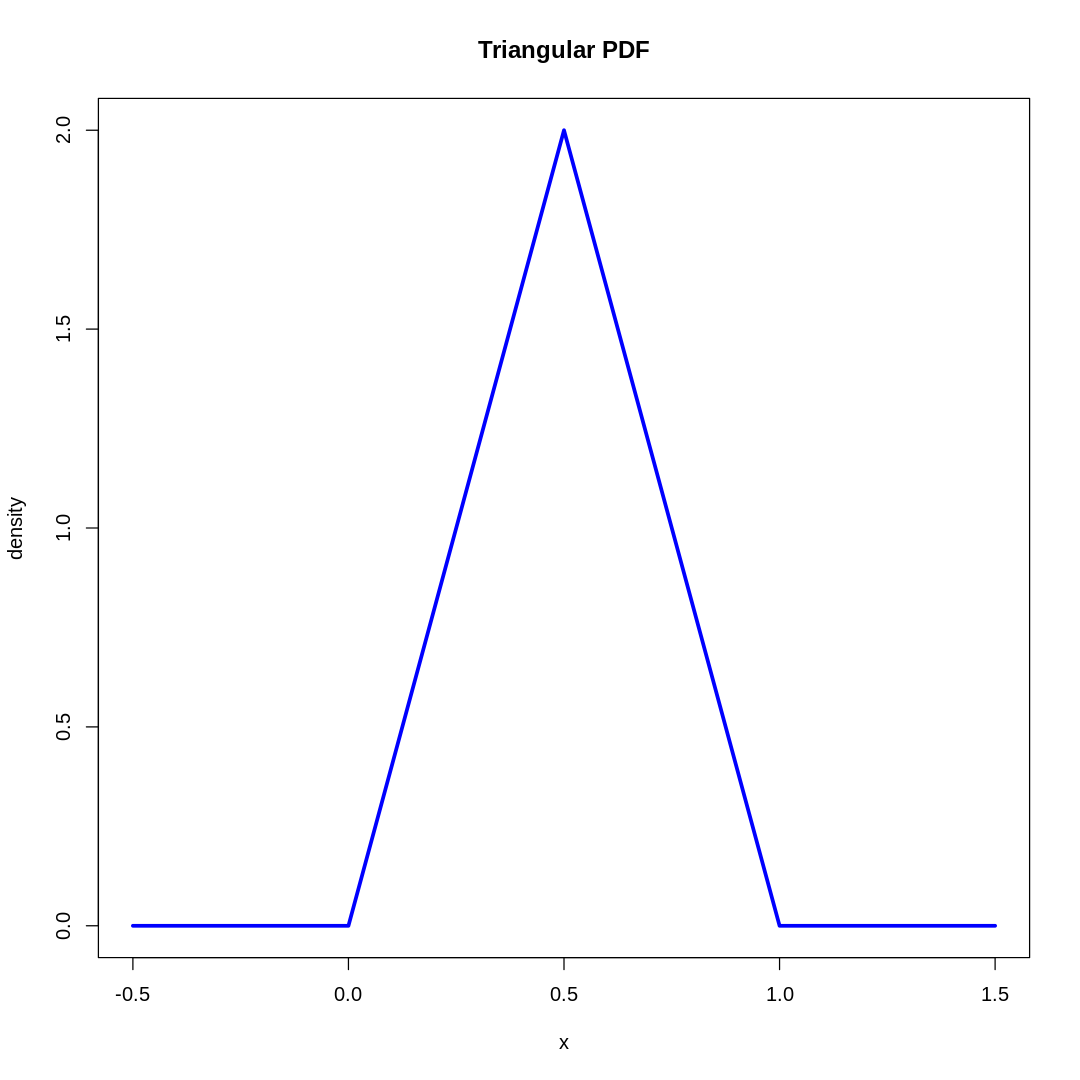

In [5]:
options(repr.plot.width=9, repr.plot.height=9)
plot(x, ddata,
     xlab='x', 
     ylab='density',
     main='Triangular PDF',
     type='l', 
     col='blue',
     lwd=3)

### 1.2. - Algorithm for random sampling from PDF <a class="anchor" id="Ex1.2."></a>

**One possibility is to write the other three R functions for statistical distributions and to exploit the function ```rtriang``` for random sampling from the PDF, using the inverse transform method. For this possibility, the following calulations are done (on Mathematica 12.1):**

$$
\text{CDF}[f](x)
=
\int_{-\infty}^{x} f(t) \ \mathrm{d}t
=
\begin{cases}
    0 & x < a \\
    \frac{(x-a)^2}{(b-a)(c-a)} & a \le x < c \\
    \frac{c-a}{b-a} - \frac{2bc}{(b-a)(b-c)} + \frac{c^2 + 2bx -x^2}{(b-a)(b-c)} & c \le x \le b \\
    1 & x >b
\end{cases}
$$

$$
\text{Quantile}[f](p)
=
(\text{CDF}[f])^{-1}(p)
=
\begin{cases}
    a + \sqrt{a^2p - abp - acp+ bcp} & 0 \le p < \frac{c-a}{b-a} \\
    b - \sqrt{-ab + b^2 + ac - bc + abp - b^2p - acp + bcp} & \frac{c-a}{b-a} \le p \le 1
\end{cases}
$$

In [6]:
ptriang <- function(x, a=0, b=1, c=0.5) {
    res <- ifelse(x>=a & x<=b,
                  ifelse(x<c,
                         (x-a)^2/((b-a)*(c-a)),
                         (c-a)/(b-a) - 2*b*c/((b-a)*(b-c)) + (c*c + 2*b*x - x*x) / ((b-a)*(b-c))),
                  ifelse(x<a,
                         0.,
                         1.))
    return(res)
}

In [7]:
# calculations done in mathematica 12.1
qtriang <- function(p, a=0, b=1, c=0.5) {
    res <- ifelse(p>=0 & p<=1,#<(c-a)/(b-a),
                  ifelse(p<(c-a)/(b-a),
                         a + sqrt(a*a*p - a*b*p - a*c*p + b*c*p),
                         b - sqrt(- a*b + b*b + a*c - b*c + a*b*p - b*b*p - a*c*p + b*c*p)),
                  "p out of bounds")
    return(res)
}

In [8]:
rtriang.inv_tsf <- function(n, a=0, b=1, c=0.5) {
    u <- runif(n)
    return(qtriang(u, a, b, c))
}

**Another possibility is to use the acceptance-rejection method. Its implementation can done with batches to speed up the computations.**

In [9]:
rtriang.acc_rej <- function(n, a=0, b=1, c=0.5, batch=1000) {
    dtriang.max <- dtriang(c, a=a, b=b, c=c)
    
    i   <- 0
    res <- c()
    while (i<=n) {
        u.1 <- runif(batch, a, b)
        u.2 <- runif(batch, 0, 1)
        y   <- ifelse(u.2*dtriang.max < dtriang(u.1, a=a, b=b, c=c), u.1, NA)
        y.c <- y[!is.na(y)]
        res <- c(res,y.c)
        i   <- i + length(y.c)
    }
    
    return(res[1:n])
}

**The importance of the batch implementation can be showed by comparing the time needed for sampling $10^4$ samples with a batch size of $1$ (so no batches) and a batch size of $1000$ (the default value).**

In [10]:
start.time.1       <- Sys.time()
rdata.acc_rej.1    <- rtriang.acc_rej(n=10000, batch=1)
end.time.1         <- Sys.time()
start.time.1000    <- Sys.time()
rdata.acc_rej.1000 <- rtriang.acc_rej(n=10000, batch=1000)
end.time.1000      <- Sys.time()
cat("Time needed (a-r with batch size 1)   :", end.time.1    - start.time.1,    "s\n")
cat("Time needed (a-r with batch size 1000):", end.time.1000 - start.time.1000, "s")

Time needed (a-r with batch size 1)   : 0.3994656 s
Time needed (a-r with batch size 1000): 0.003979921 s

**Now a comparison between the two methods is done.**

In [11]:
start.time    <- Sys.time()
rdata.inv_tsf <- rtriang.inv_tsf(n=10000)
end.time      <- Sys.time()
cat("Time needed (inverse transform):", end.time - start.time, "s")

Time needed (inverse transform): 0.01410079 s

In [12]:
for (batch_size in seq(1000,15000,500)) {
    start.time    <- Sys.time()
    rdata.acc_rej <- rtriang.acc_rej(n=10000, batch=batch_size)
    end.time      <- Sys.time()
    cat("Time needed (a-r with batch size ", 
        batch_size, 
        "): ", 
        end.time - start.time, 
        " s\n", 
        sep="")
}

Time needed (a-r with batch size 1000): 0.002788305 s
Time needed (a-r with batch size 1500): 0.004555225 s
Time needed (a-r with batch size 2000): 0.002684832 s
Time needed (a-r with batch size 2500): 0.00232935 s
Time needed (a-r with batch size 3000): 0.002688885 s
Time needed (a-r with batch size 3500): 0.002389431 s
Time needed (a-r with batch size 4000): 0.002616167 s
Time needed (a-r with batch size 4500): 0.002656221 s
Time needed (a-r with batch size 5000): 0.002836943 s
Time needed (a-r with batch size 5500): 0.002414465 s
Time needed (a-r with batch size 6000): 0.002848148 s
Time needed (a-r with batch size 6500): 0.002894163 s
Time needed (a-r with batch size 7000): 0.004175425 s
Time needed (a-r with batch size 7500): 0.002459764 s
Time needed (a-r with batch size 8000): 0.002664804 s
Time needed (a-r with batch size 8500): 0.002846241 s
Time needed (a-r with batch size 9000): 0.003167391 s
Time needed (a-r with batch size 9500): 0.00313282 s
Time needed (a-r with batch si

**It is possible to see from the previous two cells that the acceptance-rejection method performs better when an optimal batch size is given in input. So I will employ this method for the next part.**

### 1.3. - Random sampling and comparison <a class="anchor" id="Ex1.3."></a>

**Now $10^4$ samples are generated through the acceptance-rejection method, with the following parameters for the PDF:**

$$
\boxed{
a=0\\
b=1\\
c=0.3}
$$

In [13]:
n <- 10000
a <- 0
b <- 1
c <- 0.3

In [14]:
rdata <- rtriang.acc_rej(n, a=a, b=b, c=c)
dmax  <- dtriang        (c, a=a, b=b, c=c)

**Plots of the results**

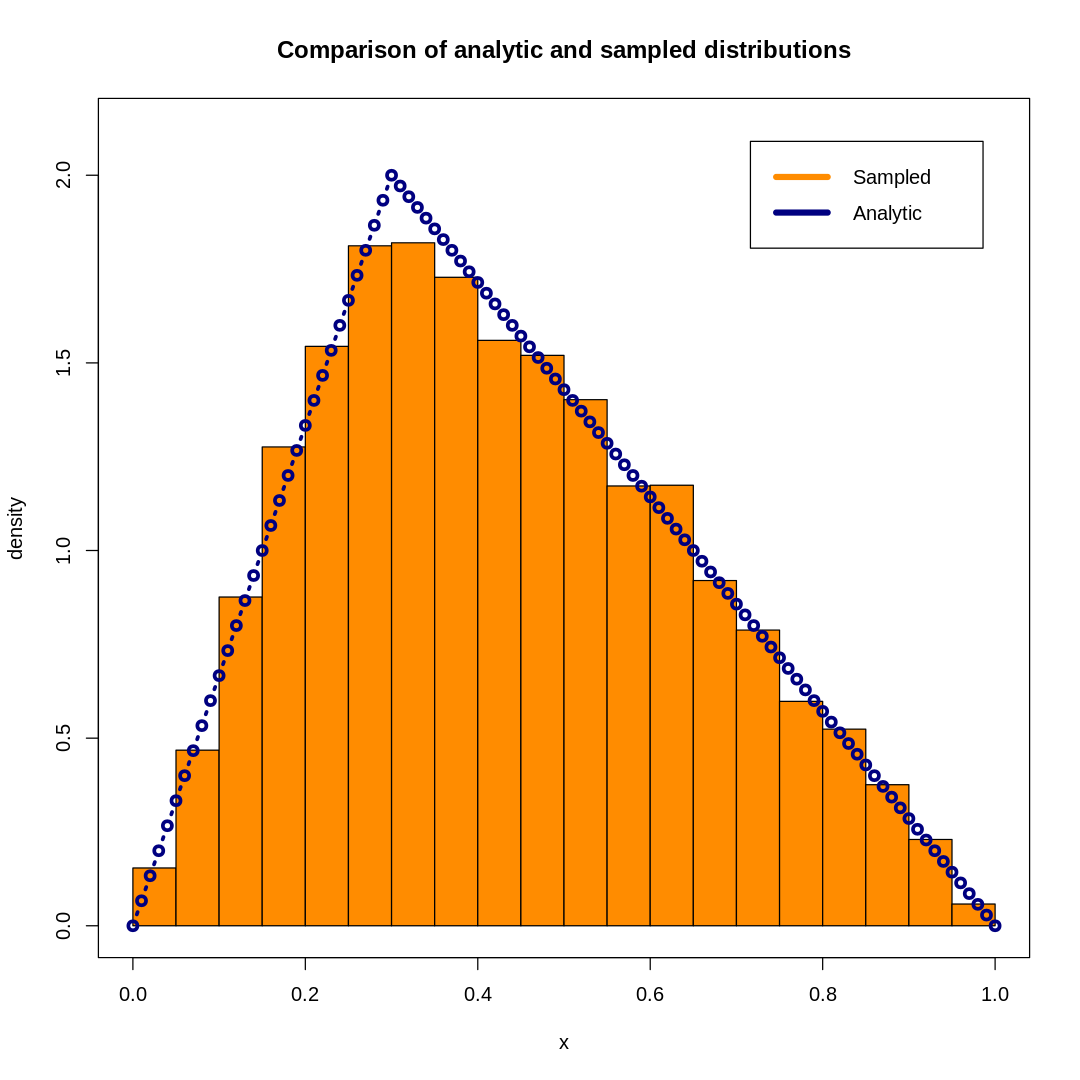

In [15]:
options(repr.plot.width=9, repr.plot.height=9)
hist (rdata, 
      col='darkorange', 
      xlab='x', 
      ylab='density', 
      ylim=c(0,1.06*dmax), 
      main='Comparison of analytic and sampled distributions',
      prob=TRUE)
curve(dtriang(x,a=a,b=b,c=c), 
      col='navy', 
      type='b', 
      lwd=3,
      add=TRUE)
legend("topright",
       inset=0.05, 
       legend=c("Sampled","Analytic"),
       col=c("darkorange", "navy"), 
       lty=1:1, 
       cex=1,
       box.lty=1,
       lwd=5)
box()

***
## Exercise 2 <a class="anchor" id="Ex2."></a>
* [Index](#ExI)
***

**Definition of the vector with the probabily values**

In [16]:
p <- c(0.05, 0.19, 0.14, 0.17, 0.02, 0.11, 0.06, 0.05, 0.04, 0.17)
x <- seq(0,length(p)-1,1)

### 2.1. - PDF and CDF <a class="anchor" id="Ex2.1."></a>

**Probability density function**

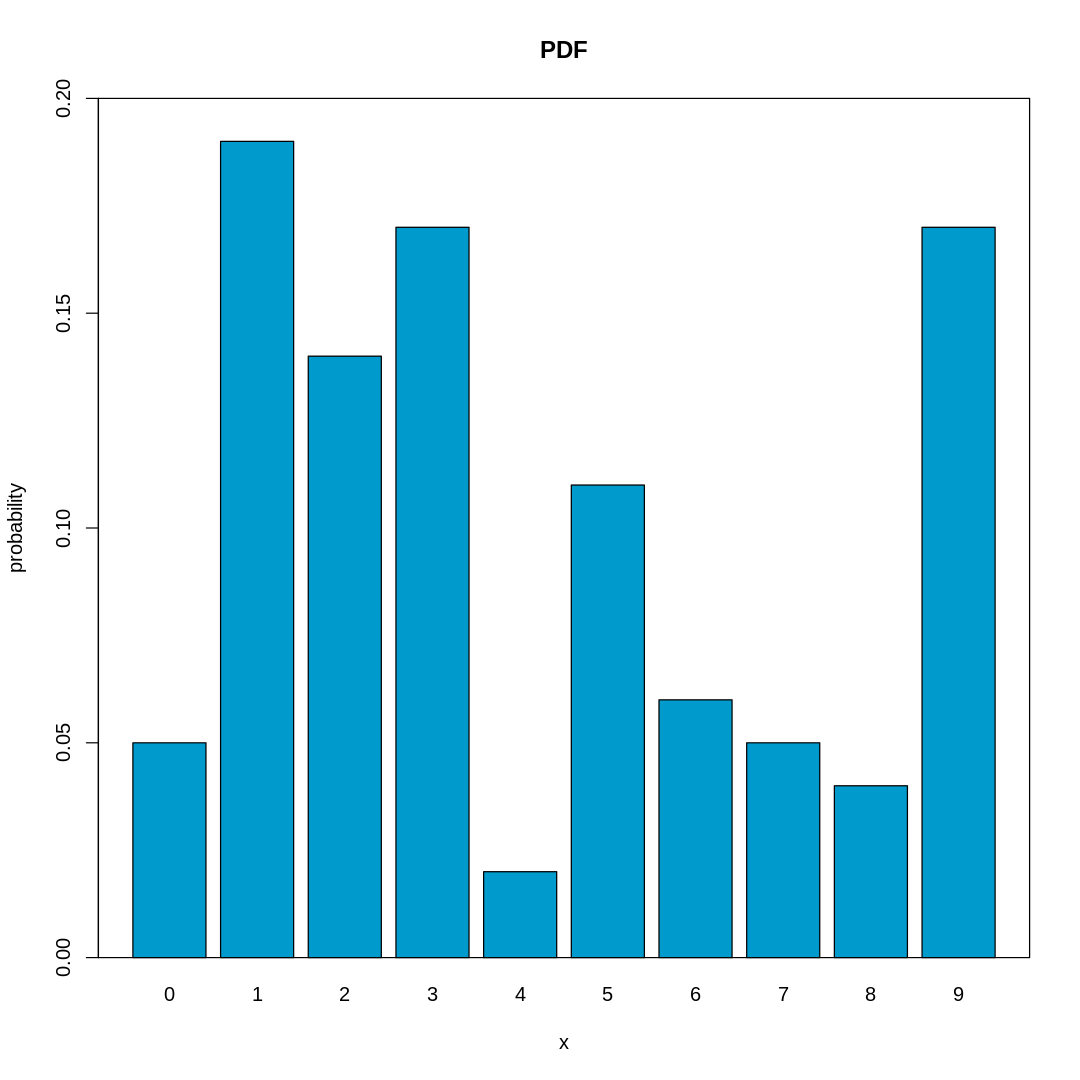

In [17]:
options(repr.plot.width=9, repr.plot.height=9)
barplot(height=p, 
        names.arg=x,
        xlab='x',
        ylab='probability',
        main='PDF',
        ylim=c(0,0.20),
        col='deepskyblue3'
        )
box()

**Cumulative Density Function**

In [18]:
pcum <- cumsum(p)

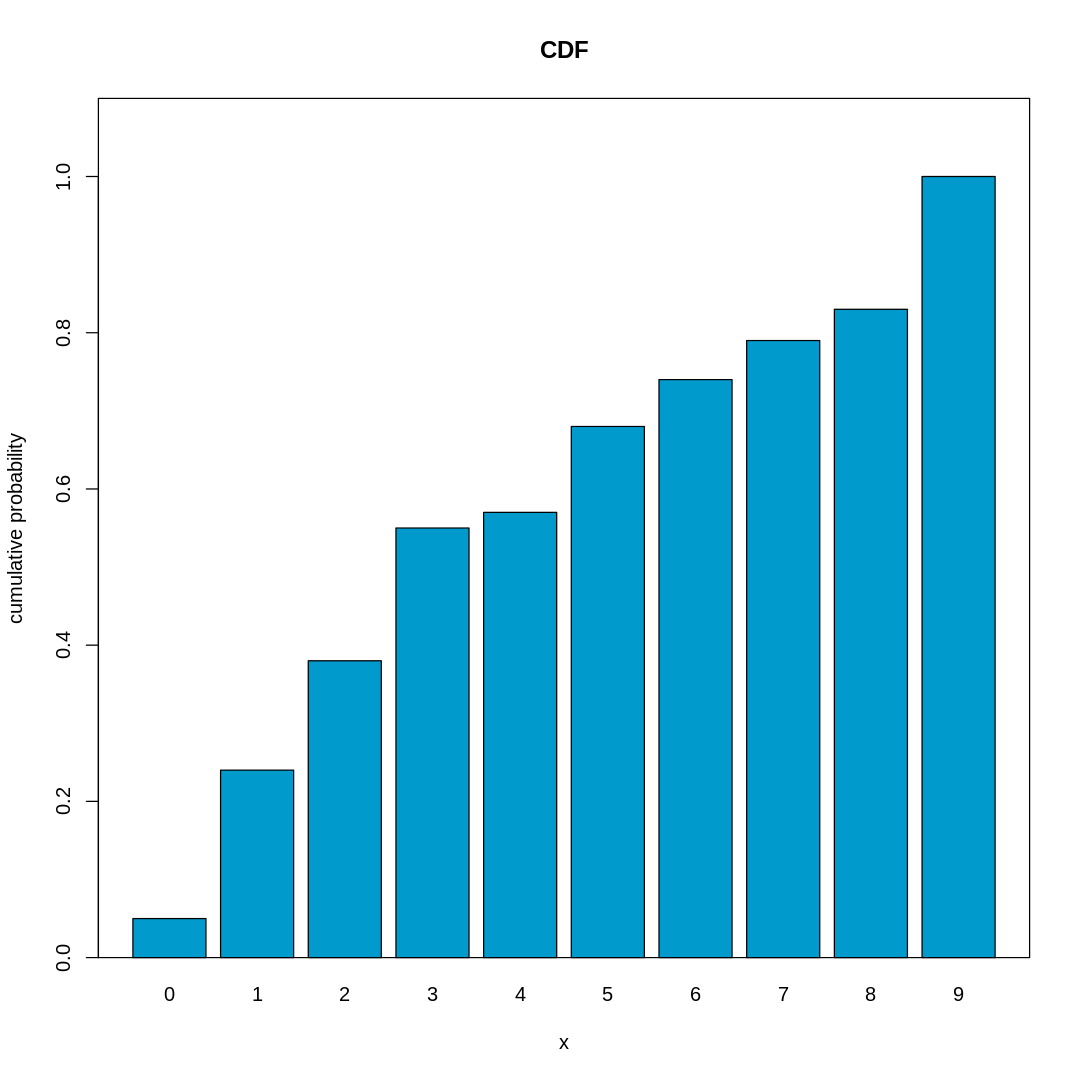

In [19]:
options(repr.plot.width=9, repr.plot.height=9)
barplot(height=pcum, 
        names.arg=x,
        xlab='x',
        ylab='cumulative probability',
        main='CDF',
        ylim=c(0,1.10),
        col='deepskyblue3')
box()

### 2.2. - Random number generator from PDF <a class="anchor" id="Ex2.2."></a>

**The method to sample from a discrete PDF is the composition sampling. In the cell below there is a possible implementation of it.**

In [20]:
rdist <- function(n, p) {
    pcum <- c(0,cumsum(p))
    u    <- runif(n)
    res  <- replicate(n,0)
    
    for (i in 1:n) {
        for (j in 1:(length(pcum)-1)) {
            if (u[i]<pcum[j+1] & u[i]>=pcum[j]) {
                res[i] <- j-1
                break
            }
        }
    }
    
    return(res)
}

**Generate $10^4$ samples and compare with the original distribution**

In [21]:
rdata <- rdist(10000, p=p)

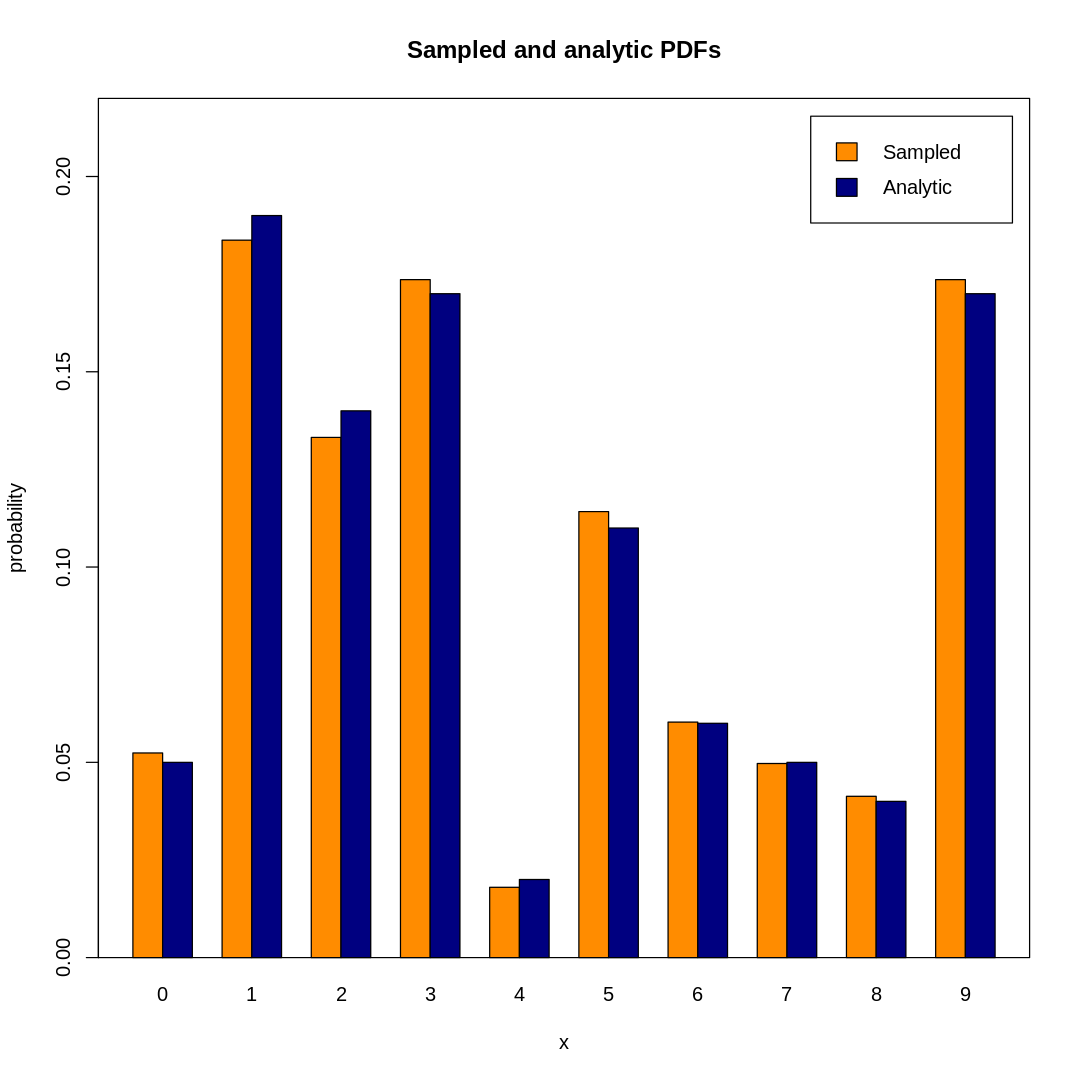

In [22]:
options(repr.plot.width=9, repr.plot.height=9)
barplot(rbind(table(rdata)/n, p),
        ylim=c(0,0.22),
        xlab='x',
        ylab='probability',
        main='Sampled and analytic PDFs',
        col=c('darkorange', 'navy'),
        legend.text=c("Sampled", "Analytic"),
        beside = TRUE)
box()

***
## Exercise 3 <a class="anchor" id="Ex3."></a>
* [Index](#ExI)
***

**Define in R the PDF given in the exercise text**

In [23]:
f <- Vectorize(function(x, r=R) {
    return((2 / (pi*r^2)) * sqrt(r^2 - x^2))
})

**Sampling algorithm (acceptance-rejection method). Its implementation is done with batches to use vectorization and speed up the computations.**

In [24]:
generate <- function(n, r=R, batch=1000) {
    f.max <- 2/(pi*r)
    
    i   <- 0
    res <- c()
    while (i<=n) {
        u.1 <- runif(batch, -r, r)
        u.2 <- runif(batch, 0, 1)
        y   <- ifelse(u.2*f.max < f(u.1, r=r), u.1, NA)
        y.c <- y[!is.na(y)]
        res <- c(res,y.c)
        i   <- i + length(y.c)
    }
    
    return(res[1:n])
}

**Generate $10^4$ random variables with $r=1$**

In [25]:
r <- 1

In [26]:
rdata <- generate(10000, r=r)

**Comparison of sampled and analytic distributions for $r=1$**

In [27]:
x <- seq(-r,r,0.01)

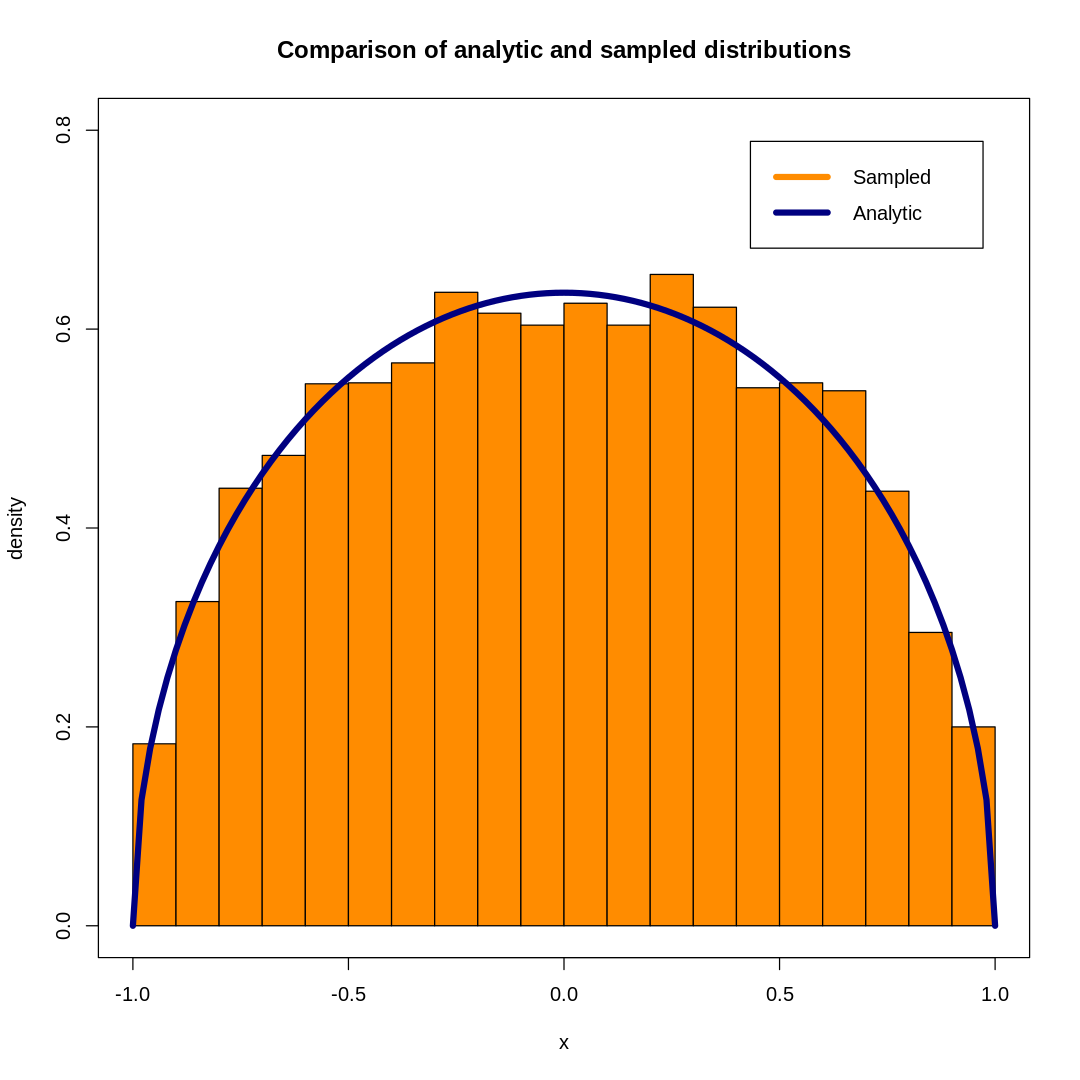

In [28]:
options(repr.plot.width=9, repr.plot.height=9)
hist(rdata, 
     prob=TRUE, 
     xlim=c(-r,r), 
     ylim=c(0,0.8), 
     xlab='x',
     ylab='density',
     main='Comparison of analytic and sampled distributions',
     col='darkorange')
curve(f(x,r=r), 
      col='navy', 
      type='l', 
      lwd=5,
      add=TRUE)
legend("topright",
       inset=0.05, 
       legend=c("Sampled","Analytic"),
       col=c("darkorange", "navy"), 
       lty=1:1, 
       cex=1,
       box.lty=1,
       lwd=5)
box()

***
## Exercise 4 <a class="anchor" id="Ex4."></a>
* [Index](#ExI)
***

**Before starting with the exercise, let's consider the sampling rule:**

$$
Y
=
\sum_{i=1}^{m} X_i
=
\beta \sum_{i=1}^{m} (- \log U_i)
=
\beta
\log \left(\prod_{i=1}^{m} U_i
\right)
$$

**where $X_i \sim \text{Exp}(\beta)$ and $U_i \sim \text{Unif}(0,1)$.**

**Sampling algorithm**

In [29]:
rerlang <- function(n=1, m=1, beta=1) {
    u <- matrix(runif(n*m), nrow=n, ncol=m)
    y <- -beta*log(apply(u, 1, prod))
    return(y)
}

**Result for:**

$$
\boxed{m=10\\\beta=2}
$$

**and comparison with $\text{Gamma}(m,\beta)$ (to enlarge the plot, double-click it).**

In [30]:
n     <- 100000
shape <- 10    # m
scale <- 2     # beta

In [31]:
rdata <- rerlang(n=n, m=shape, beta=scale)

In [32]:
min   <- min(as.numeric(names(table(round(rdata,0)))))
max   <- max(as.numeric(names(table(round(rdata,0)))))
x     <- as.numeric(names(table(round(rdata,0)))) #seq(min, max, 1)
ddata <- dgamma(x, shape=shape, scale=scale)

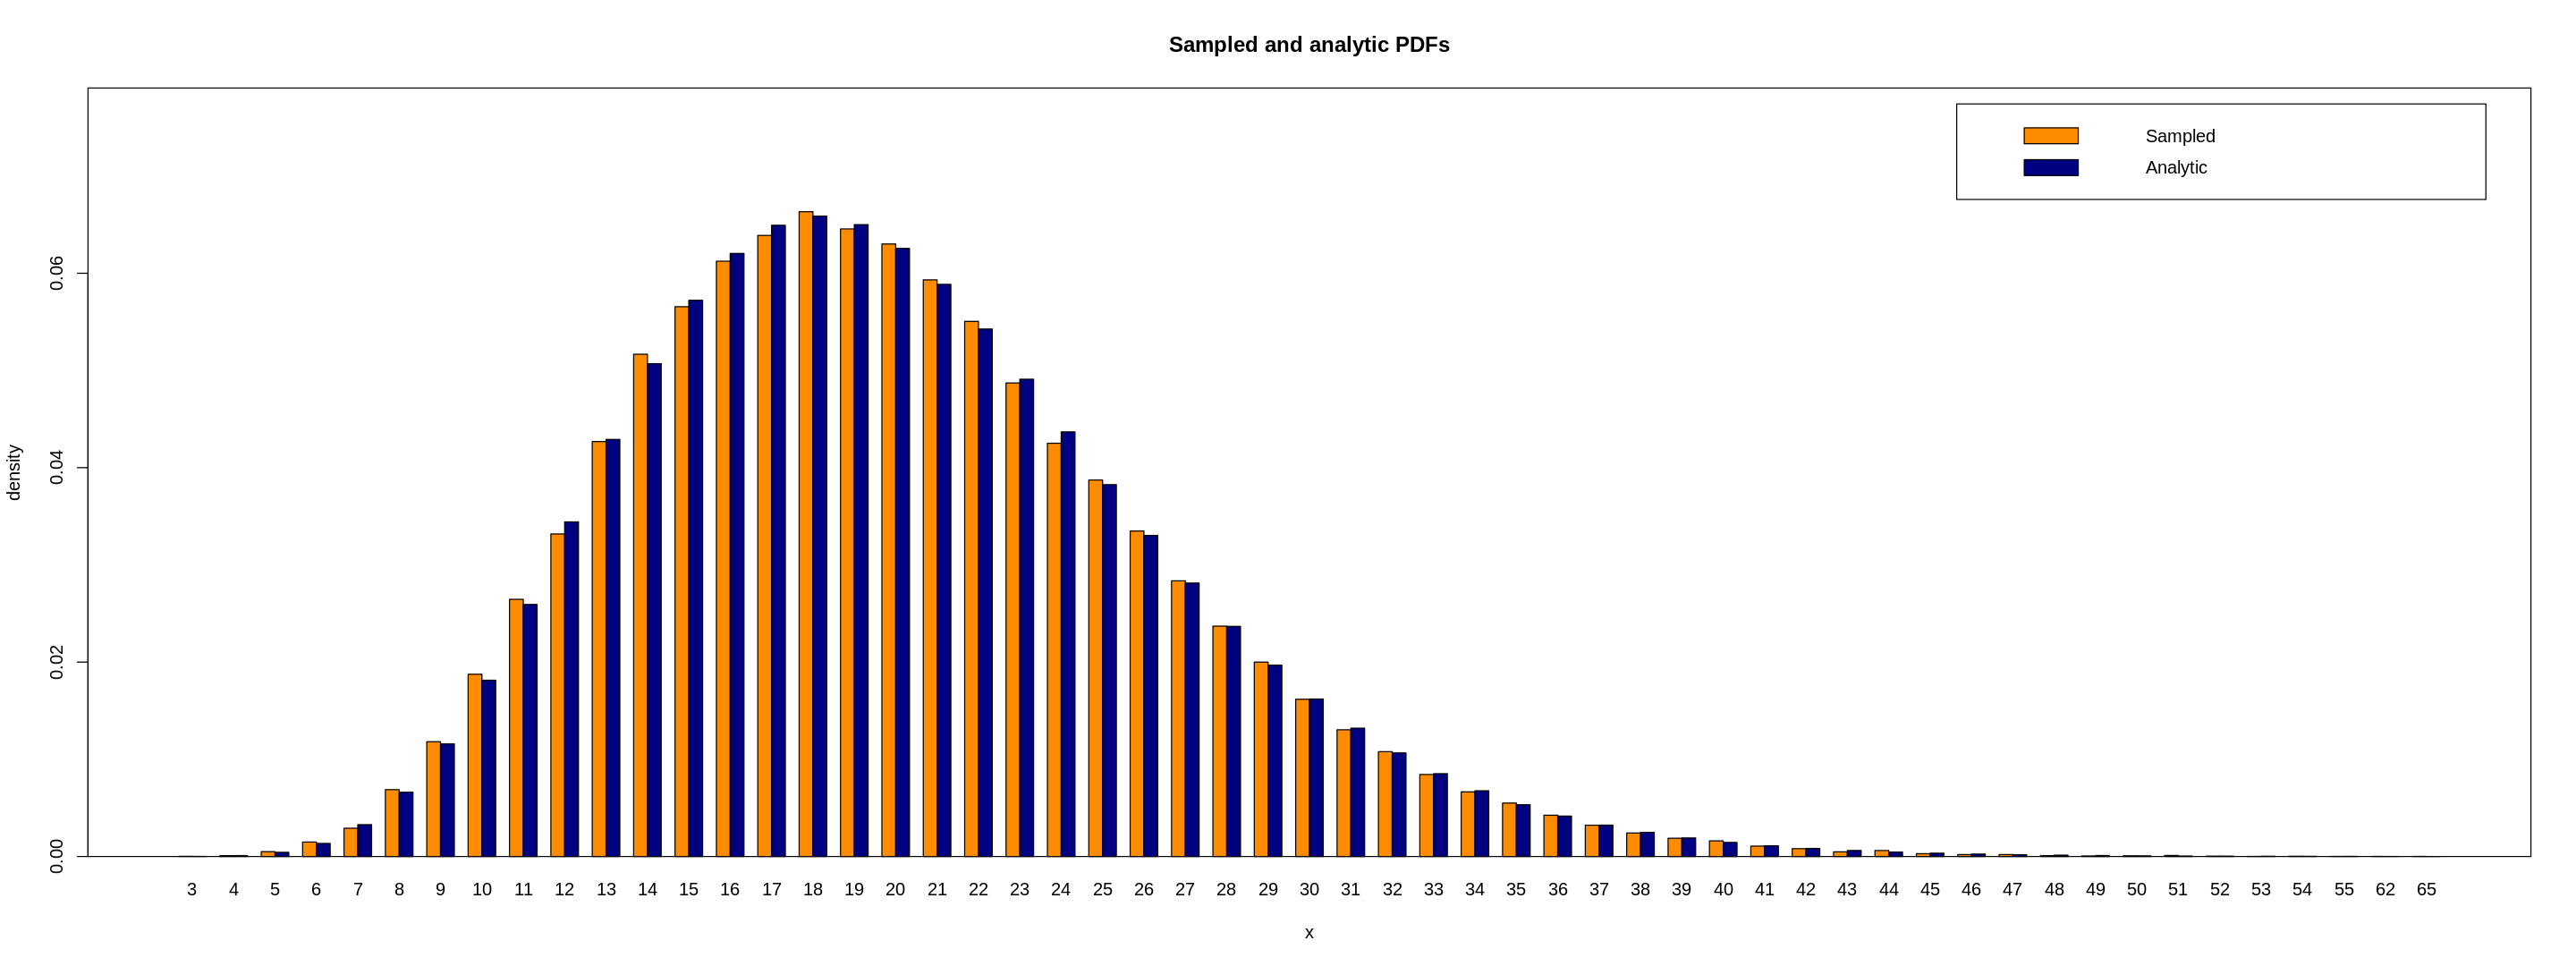

In [33]:
options(repr.plot.width=24, repr.plot.height=9)
barplot(rbind(table(round(rdata,0))/n, ddata),
        ylim=c(0,1.2*max(ddata)),
        xlab='x',
        ylab='density',
        main='Sampled and analytic PDFs',
        col=c('darkorange', 'navy'),
        legend.text=c("Sampled", "Analytic"),
        beside = TRUE)
box()

***
## Exercise 5 <a class="anchor" id="Ex5."></a>
* [Index](#ExI)
***

**Definition of ```%notin%``` operator (convenient for the implementation of middle square generator algorithm in the next cells)**

In [34]:
`%notin%` <- Negate(`%in%`)

**Middle square generator algorithm implementation. A seed of $k$ digits is given as input and the function returns the related (pseudo)-random sequence (the whole cycle). It works with both even and odd $k$s.**

In [35]:
msg <- function(seed=123456, DEBUG=FALSE) {
    sequence <- NULL
    num      <- seed
    seed.len <- length(unlist(strsplit(as.character(seed),"")))
    
    if (seed.len%%2 == 0) {
        head.len <- seed.len/2
        tail.len <- seed.len/2
    }
    else {
        head.len <- floor(seed.len/2)
        tail.len <- floor(seed.len/2)+1
    }
    
    while (TRUE) {
        seed.squared <- num^2
        seed.squared <- unlist(strsplit(as.character(seed.squared),""))
        seed.squared <- c(rep('0',seed.len*2 - length(seed.squared)), seed.squared)
        num          <- seed.squared[(head.len+1):(seed.len*2-tail.len)]
        num          <- as.numeric(paste(num, collapse=""))
        
        if (num %notin% sequence) {
            sequence <- c(sequence, num)
        }
        else {
            break
        }
    }
    
    return(sequence)
}

**To check if everything works correctly, a comparison with the following graph for $k=2$ digits is given.**

![k=2](https://hbfs.files.wordpress.com/2017/09/middle-square-10.png)

In [36]:
msg(69)

[1] 76 77 92 46 11 12 14 19 36 29 84  5  2  0

**The results is the same of the one in the graph.**

**Now, it is interesting to study the sequence length depending on the number of digits of the seed. For this purpose, it is convenient to study the distribution of the sequence length by applying ```msg``` function to every number of $k$ digits.**

In [37]:
seq.length.study <- function(k) {
    msg.v <- Vectorize(msg)
    seq.l <- NULL

    min.s <- 10^(k-1)
    max.s <- 10^k - 1
    #seeds <- c(min.s:max.s)

    seq.l <- msg.v(c(min.s:max.s))
    #for (seed in min.s:max.s) {
    #    seq.l <- c(seq.l, length(msg(seed)))
    #}
    
    return(lengths(seq.l))
}

In [38]:
seq.l.k.1 <- table(seq.length.study(1))
seq.l.k.2 <- table(seq.length.study(2))
seq.l.k.3 <- table(seq.length.study(3))
seq.l.k.4 <- table(seq.length.study(4))
seq.l.k.5 <- table(seq.length.study(5))

**Result for $k=1$ digit**

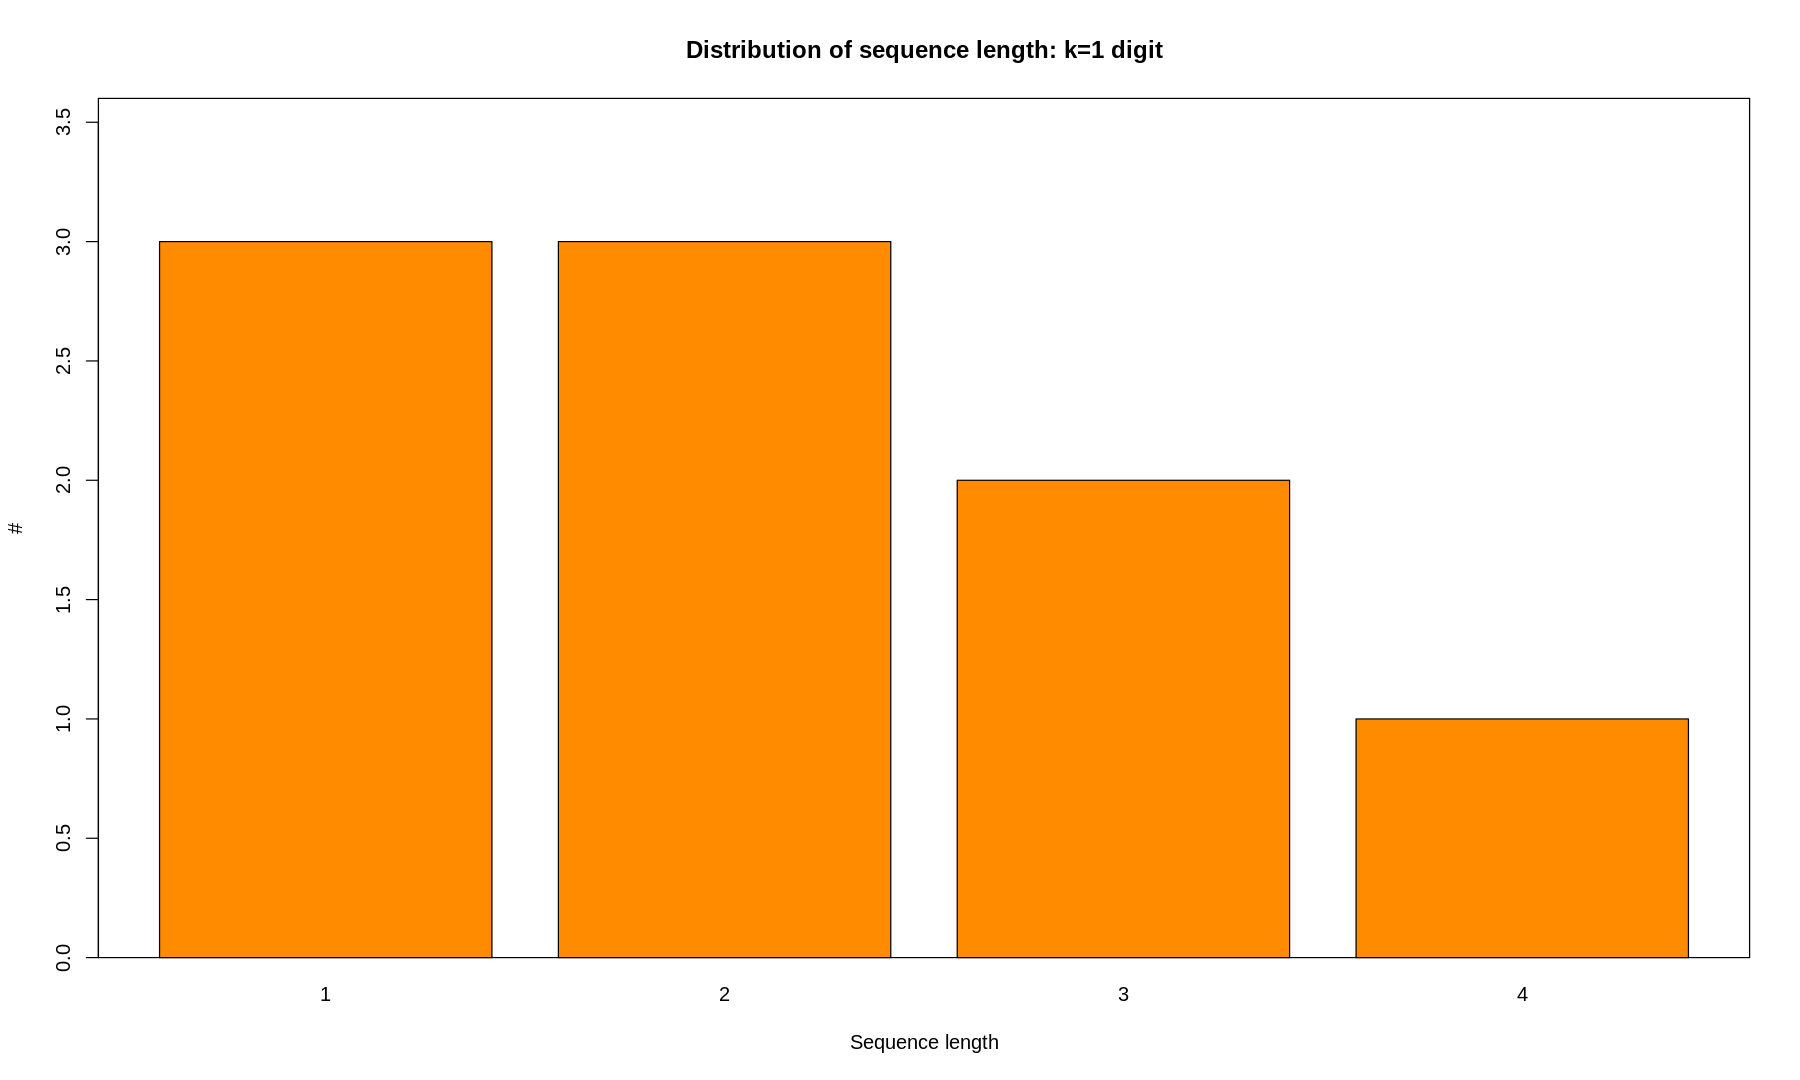

In [39]:
options(repr.plot.width=15, repr.plot.height=9)
barplot(seq.l.k.1,
        xlab='Sequence length',
        ylab='#',
        ylim=c(0,1.2*max(seq.l.k.1)),
        main='Distribution of sequence length: k=1 digit',
        col='darkorange')
box()

**Result for $k=2$ digits**

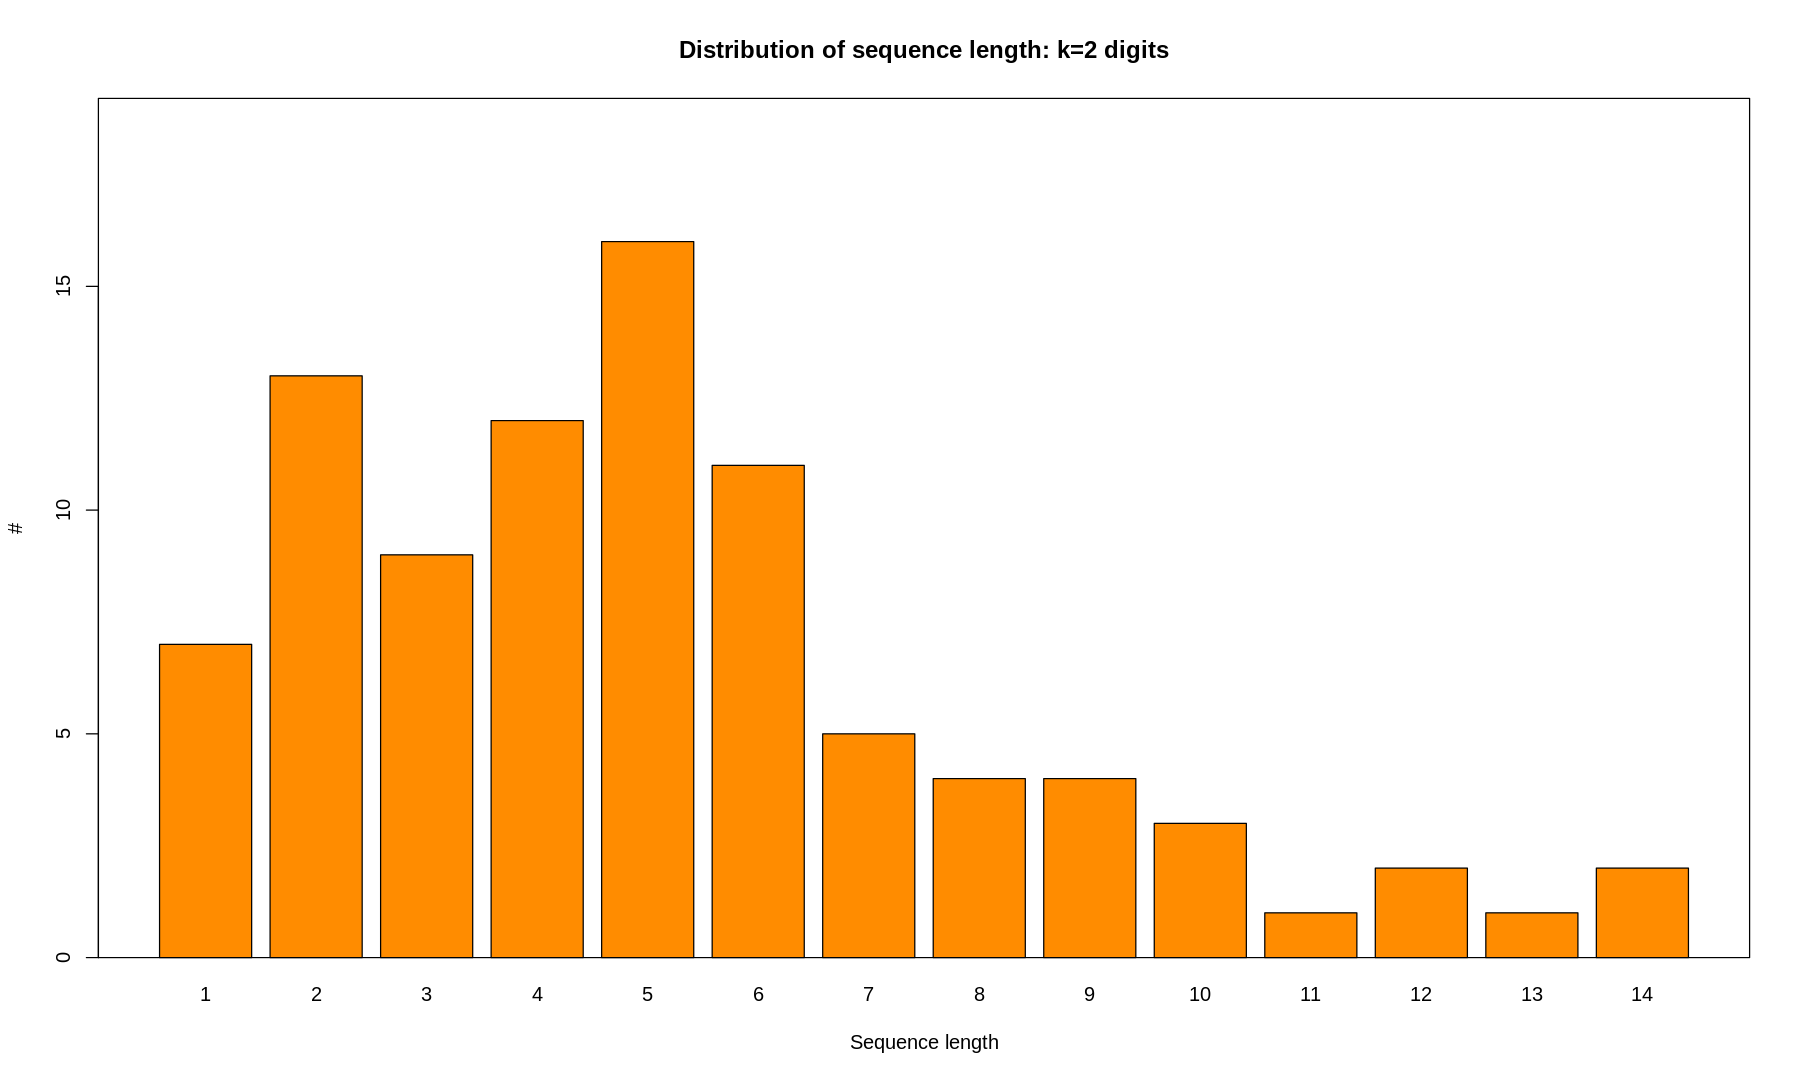

In [40]:
options(repr.plot.width=15, repr.plot.height=9)
barplot(seq.l.k.2,
        xlab='Sequence length',
        ylab='#',
        ylim=c(0,1.2*max(seq.l.k.2)),
        main='Distribution of sequence length: k=2 digits',
        col='darkorange')
box()

**Result for $k=3$ digits**

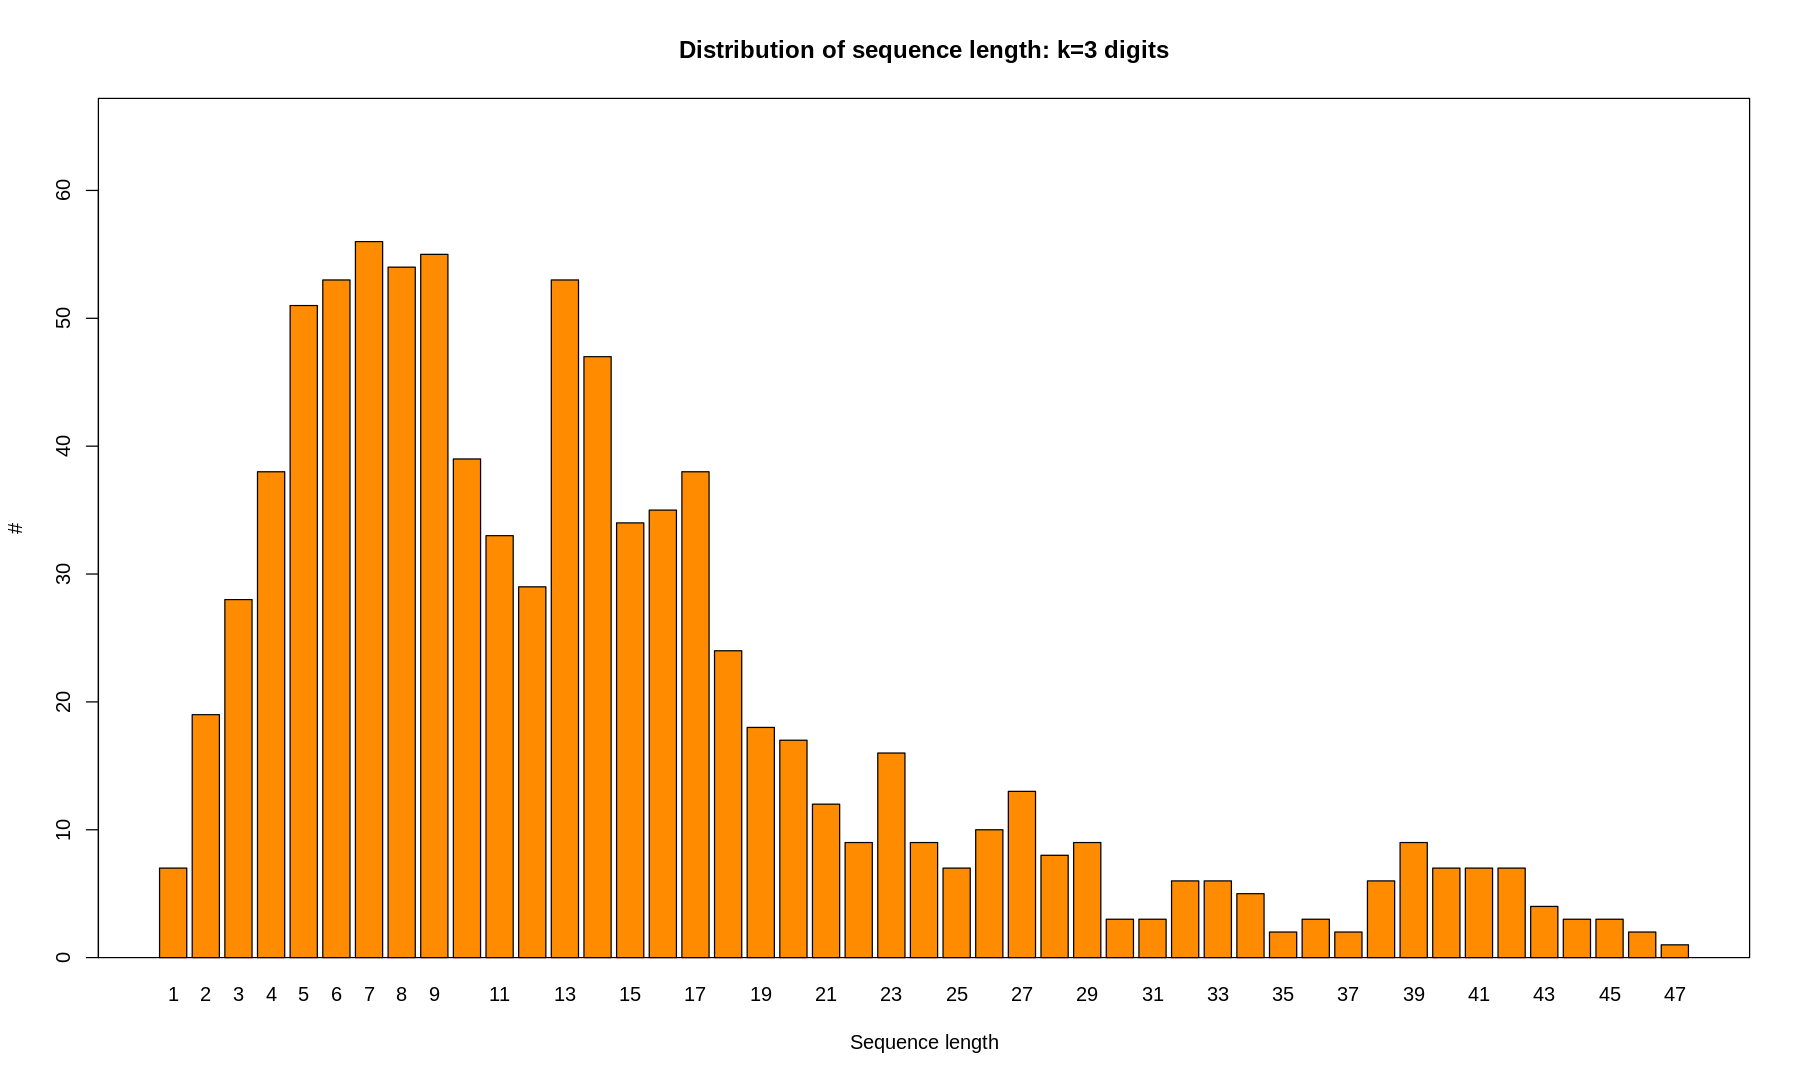

In [41]:
options(repr.plot.width=15, repr.plot.height=9)
barplot(seq.l.k.3,
        xlab='Sequence length',
        ylab='#',
        ylim=c(0,1.2*max(seq.l.k.3)),
        main='Distribution of sequence length: k=3 digits',
        col='darkorange')
box()

**Result for $k=4$ digits**

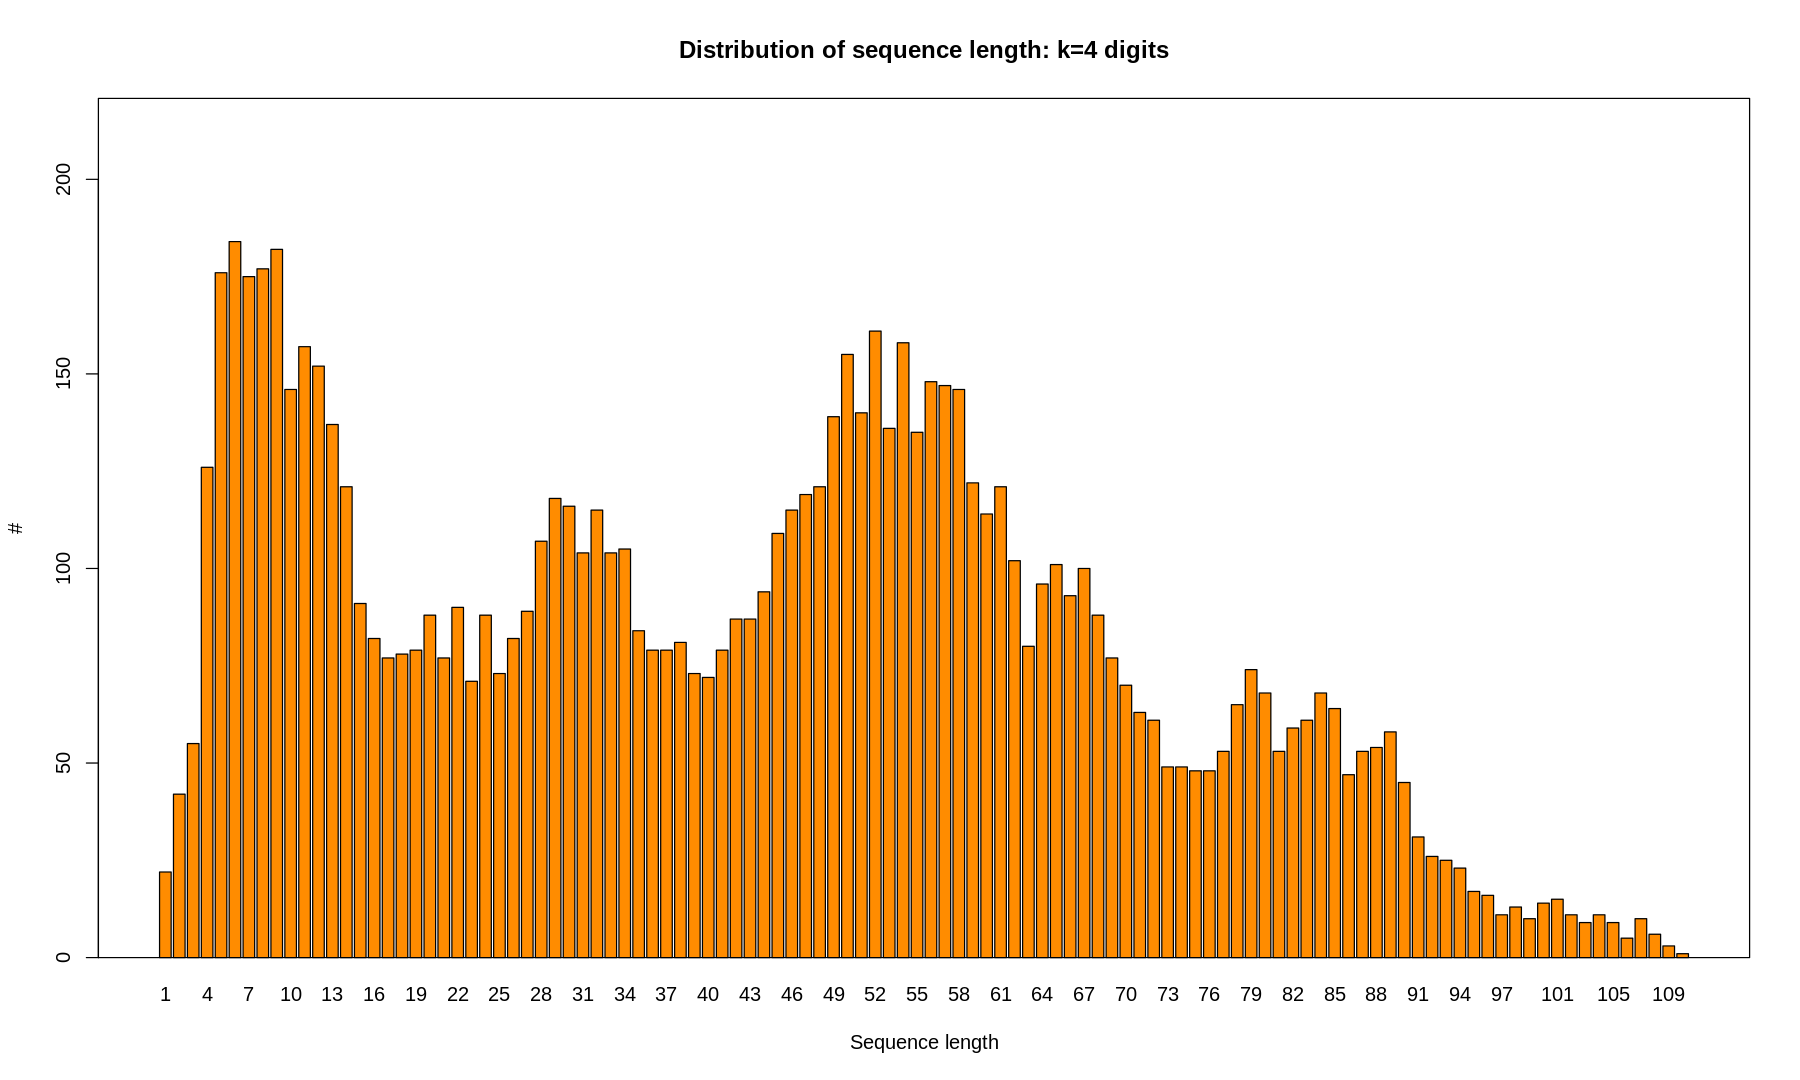

In [42]:
options(repr.plot.width=15, repr.plot.height=9)
barplot(seq.l.k.4,
        xlab='Sequence length',
        ylab='#',
        ylim=c(0,1.2*max(seq.l.k.4)),
        main='Distribution of sequence length: k=4 digits',
        col='darkorange')
box()

**Result for $k=5$ digits**

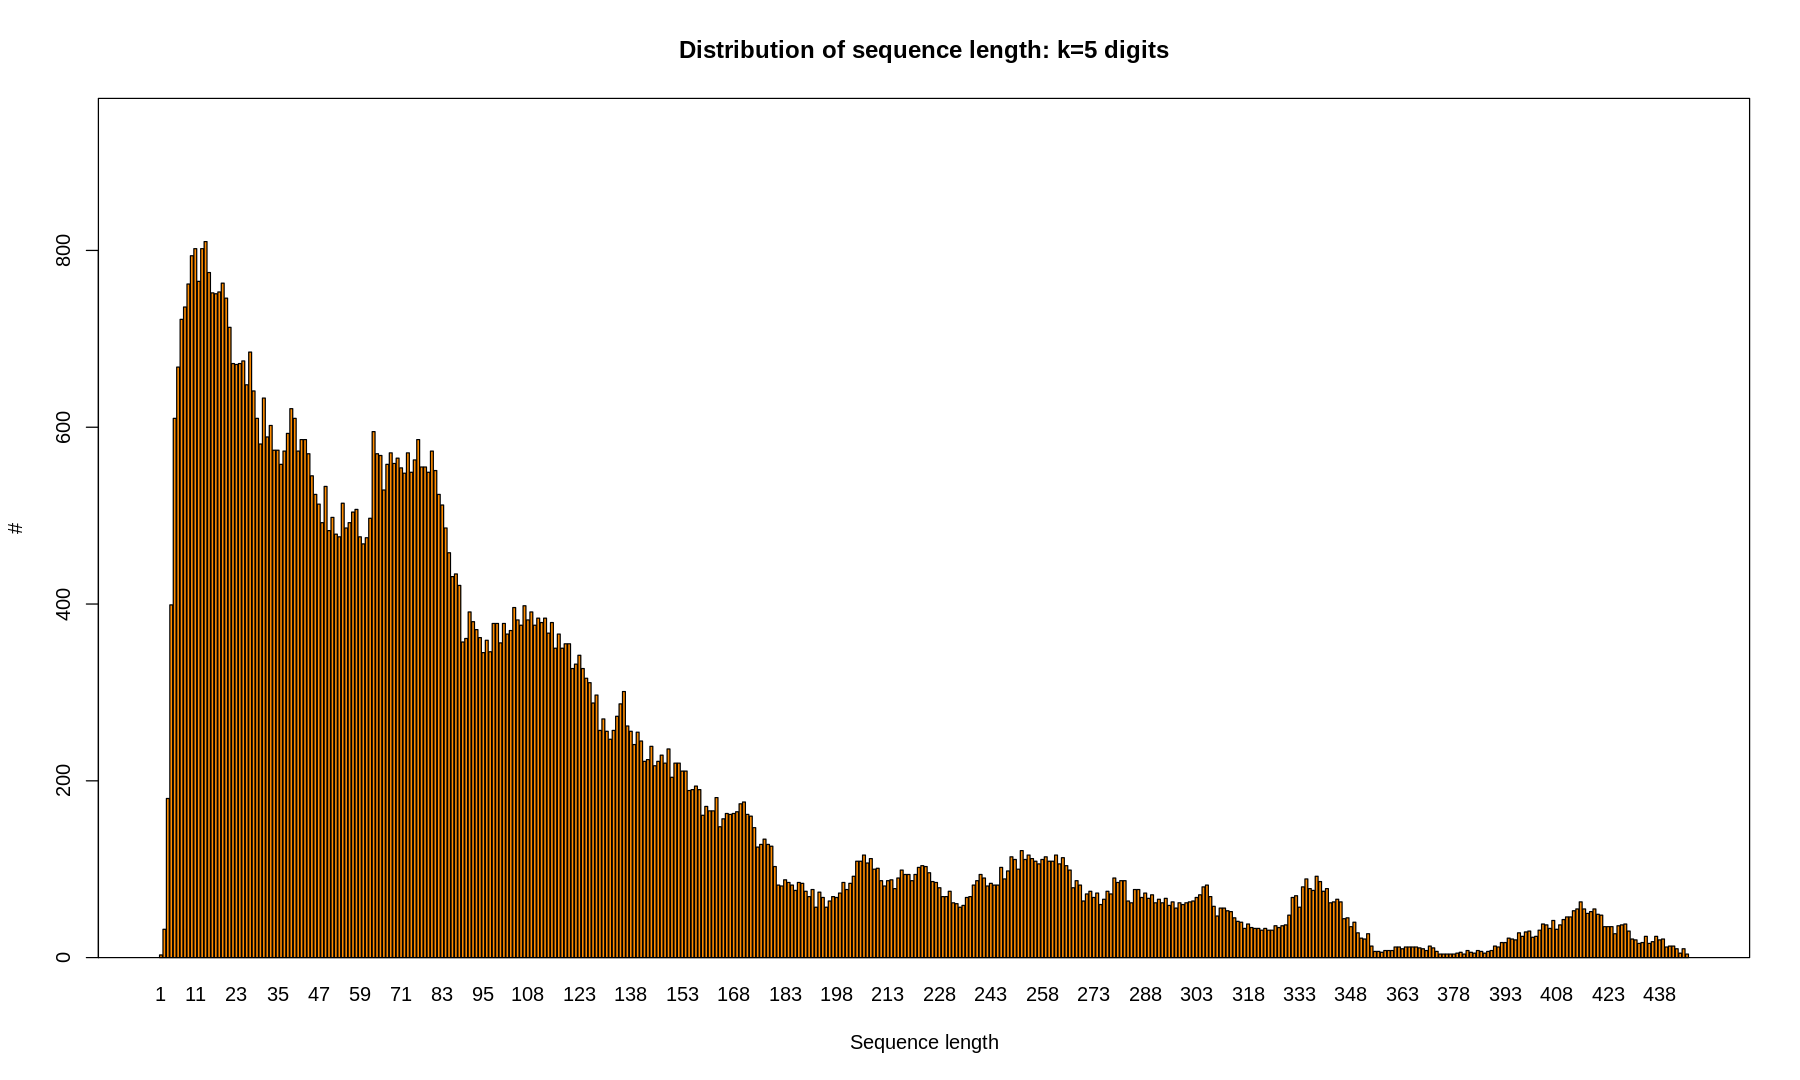

In [43]:
options(repr.plot.width=15, repr.plot.height=9)
barplot(seq.l.k.5, 
        xlab='Sequence length',
        ylab='#',
        ylim=c(0,1.2*max(seq.l.k.5)),
        main='Distribution of sequence length: k=5 digits',
        col='darkorange')
box()

**In conclusion, as it is possible to see from the results above on sequence lengths for several values of $k$, this method is not an efficient one to generate pseudo-random numbers.**